In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import censusdata
import re
import geopandas

censuskey = '7b3e8a6afe58867abcf5aecad26845d802115f1f'

In [250]:
#Define Funtions

#Funcion For NonDigit Removing Characters from Row - Used for Extracting GEOID
def remove_chars(s):
    clean = int(re.sub('[^0-9]+', '', str(s))[-11:])
    return clean

#Function to get census data according to requirements
def getcensustables(table):
    tablename = 'data_' + table
    print(f'Downloading {table}')
    
    # Set requirements to pull from Census API
    
    variablestopull = allvariablescsv.loc[allvariablescsv['Group']==table]['Name'].tolist()
    listofcounties = ['121', '089']
    yearstopull = range(2015,2018,1)

    #Pull Census Data according to requirement above
    atlantadata = pd.DataFrame()

    for year in yearstopull:
        for county in listofcounties:

            newdata = censusdata.download('acs5', year, censusdata.censusgeo([('state', '13'), ('county', county), ('tract', '*')]),variablestopull,censuskey)
            type(newdata)
            newdata['YEAR'] = year
            atlantadata = atlantadata.append(newdata)

    #Rename Column Headings from Code to Text
    for variable in variablestopull:
        #print(variable)
        renamevar1 = allvariablescsv.loc[allvariablescsv['Name']==variable]['Label'].iloc[0]
        renamevar2 = allvariablescsv.loc[allvariablescsv['Name']==variable]['Concept'].iloc[0]
        renamevar = renamevar2 + '_'+ renamevar1
        #print(renamevar)
        atlantadata = atlantadata.rename(columns={variable: renamevar})

    #Transform Index to create GeoID

    #Create GeoID Column
    atlantadata['Name2'] = atlantadata.index
    atlantadata['GEOID'] = atlantadata['Name2'].apply(remove_chars)
    atlantadata.drop(columns=['Name2'], inplace=True)
    
    #Only Keep Atlanta Census Tracts(Geocodes)
    finaldata = atlantageocodes.merge(atlantadata, how='left', on='GEOID')
    
    finaldata = finaldata.dropna(axis=0, how='any')
    
    return finaldata

In [306]:
#Code Begins here

#Tables to Load from data/tablestopull.csv
tablestoloadcsv = pd.read_csv('data/tablestopull.csv')
tablestoload = tablestoloadcsv['Tables'].tolist()

#Uncommnent Line below to override csv
#tablestoload = ['B19013','B01003','B11001', 'B25064', 'B25074','B25063', 'B25061','B25056','B00002','B25001','B25122']

#Allvariables Table to get table detail
allvariablescsv = pd.read_csv('data/allvariables.csv')

#Atlanta Geo Codes Table to filter to city of atlanta only 
atlantageocodes = pd.read_csv('data/atlantageocodes.csv')

#Create dictionary with each cleaned table as an entry
alltables = dict()  


#Script will attempt to load tables from data folder first, otherwise download them
for table in tablestoload:
    try:
        data = pd.read_csv('data/' + table + '.csv')
        alltables[table] = data
        print(f'Loading {table}')
    except:
        data = getcensustables(table)
        alltables[table] = data

        data.to_csv('data/' + table + '.csv')
        
        

Loading B19013
Loading B01003
Loading B11001
Loading B25064
Loading B25074
Loading B25063
Loading B25061
Loading B25056
Loading B00002
Loading B25001
Loading B25122


In [47]:
#Pull HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS and group by year
percentrentbyincome = alltables['B25074']
percentrentbyincome = percentrentbyincome.groupby('YEAR').sum()
percentrentbyincome = percentrentbyincome.transpose()


#Split index into variables
percentrentbyincome['YEAR'] = percentrentbyincome.index
split1 = percentrentbyincome['YEAR'].str.split('PAST 12 MONTHS_Estimate!!Total!!', expand=True)
split2 = split1[1].str.split('!!', expand=True)

percentrentbyincome['Income'] = split2[0]
percentrentbyincome['Rent as % of Income'] = split2[1]

percentrentbyincome.drop(columns='YEAR')


#Set years to loop through
years = [2014.0,2015.0,2016.0,2017.0]

percentrentbyincome2 = percentrentbyincome.copy()


for year in years:

    print(year)
    percentrentbyincome = percentrentbyincome2[[year,'Income','Rent as % of Income']]

    #display(percentrentbyincome)
    percentrentbyincome = percentrentbyincome.dropna(axis=0, how='any')
    #display(percentrentbyincome)
    # display(percentrentbyincome.pivot(index=percentrentbyincome['Income'], columns=percentrentbyincome['Rent Change'], values=percentrentbyincome[2012.0]))

    percentrentbyincomepv = pd.crosstab(index=percentrentbyincome.iloc[:,1], columns=percentrentbyincome.iloc[:,2], 
                      values=percentrentbyincome.iloc[:,0], aggfunc='mean')

    percentrentbyincomepv['TotalHHs'] = percentrentbyincomepv.sum(axis = 1, skipna = True) 

    percentrentbyincomepv = percentrentbyincomepv.div(percentrentbyincomepv.TotalHHs, axis=0)*100

    display(percentrentbyincomepv)

2014.0


Rent as % of Income,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Less than 20.0 percent,TotalHHs
Income,,,,,,,,
"$10,000 to $19,999",3.850150,7.119721,4.675182,3.391799,10.639858,64.566400,5.756891,100.0
"$100,000 or more",7.687028,2.000196,0.686342,0.421610,1.343269,0.588293,87.273262,100.0
"$20,000 to $34,999",4.072620,10.385999,14.534947,17.102824,21.431687,27.848653,4.623269,100.0
"$35,000 to $49,999",19.078490,29.073088,21.988115,10.712356,8.605387,2.909624,7.632940,100.0
"$50,000 to $74,999",33.556861,20.076046,9.305219,3.574144,3.601797,1.016246,28.869685,100.0
"$75,000 to $99,999",23.337193,8.658176,2.778850,1.222179,0.180111,0.501737,63.321755,100.0
"Less than $10,000",2.239118,7.282366,4.066685,2.734375,4.031808,76.813616,2.832031,100.0


2015.0


Rent as % of Income,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Less than 20.0 percent,TotalHHs
Income,,,,,,,,
"$10,000 to $19,999",3.578407,6.820957,4.445530,3.529555,10.454323,65.944064,5.227162,100.0
"$100,000 or more",7.057891,2.511234,0.643228,0.563926,1.092607,0.458190,87.672923,100.0
"$20,000 to $34,999",3.757241,9.853793,15.216552,16.805517,23.155862,27.128276,4.082759,100.0
"$35,000 to $49,999",19.131297,30.149508,19.521009,11.287465,8.481542,2.975980,8.453199,100.0
"$50,000 to $74,999",33.209925,19.608989,9.398545,3.903611,3.143674,0.785918,29.949337,100.0
"$75,000 to $99,999",23.937065,9.656498,1.969733,1.861638,0.396349,0.468412,61.710305,100.0
"Less than $10,000",2.342522,7.191830,3.213827,2.328239,4.549350,77.481788,2.892444,100.0


2016.0


Rent as % of Income,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Less than 20.0 percent,TotalHHs
Income,,,,,,,,
"$10,000 to $19,999",4.857345,7.032539,4.715869,3.684273,10.587126,64.389295,4.733553,100.0
"$100,000 or more",8.547758,3.560902,0.318649,0.454075,0.414244,0.000000,86.704373,100.0
"$20,000 to $34,999",3.314739,10.566402,15.350783,15.023600,24.581635,26.523278,4.639562,100.0
"$35,000 to $49,999",17.431256,28.824098,20.450463,11.655382,9.769241,4.829349,7.040210,100.0
"$50,000 to $74,999",32.778426,21.880951,9.453898,5.024879,2.979298,0.921433,26.961116,100.0
"$75,000 to $99,999",27.628220,9.190067,3.249014,2.007426,0.545370,0.011604,57.368299,100.0
"Less than $10,000",2.131887,6.349813,4.959120,1.528234,4.546497,77.122335,3.362115,100.0


2017.0


Rent as % of Income,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Less than 20.0 percent,TotalHHs
Income,,,,,,,,
"$10,000 to $19,999",5.475880,7.704725,5.004036,2.905569,9.567269,63.624511,5.718011,100.0
"$100,000 or more",9.751597,3.484741,0.567779,0.681334,0.461320,0.000000,85.053229,100.0
"$20,000 to $34,999",3.603555,8.870706,15.319172,14.863986,24.666739,27.408692,5.267151,100.0
"$35,000 to $49,999",15.641559,27.406265,21.275739,12.468978,10.463478,5.426253,7.317728,100.0
"$50,000 to $74,999",30.452190,22.550636,11.287094,6.824070,3.674046,0.995054,24.216910,100.0
"$75,000 to $99,999",31.141072,12.232818,3.836457,2.192261,0.569988,0.131536,49.895868,100.0
"Less than $10,000",3.431972,7.312301,4.369446,1.785278,4.891171,74.949050,3.260781,100.0


In [335]:
#Pull HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS and group by year

percentrentbyincome = alltables['B25074']
percentrentbyincome = percentrentbyincome.groupby('YEAR').sum() 
percentrentbyincome = percentrentbyincome.transpose()


#Split index into variables

percentrentbyincome['YEAR'] = percentrentbyincome.index
split1 = percentrentbyincome['YEAR'].str.split('PAST 12 MONTHS_Estimate!!Total!!', expand=True)
split2 = split1[1].str.split('!!', expand=True)
percentrentbyincome['Income'] = split2[0]
percentrentbyincome['Rent as % of Income'] = split2[1]
percentrentbyincome.drop(columns='YEAR')

#Set years of ACS5 to loop
years = [2015.0,2016.0,2017.0]


#Loop through the years of ACS5 to create a single organized dataframe
percentrentbyincomesum = pd.DataFrame()
percentrentbyincome2 = percentrentbyincome.copy()
percentrentbyincomesum2 = percentrentbyincomesum.copy()

for year in years:
    
    #Keep only relevant data points
    percentrentbyincome = percentrentbyincome2[[year,'Income','Rent as % of Income']]
    percentrentbyincome = percentrentbyincome.dropna(axis=0, how='any')
    
    #Create Matrix from Data
    percentrentbyincomepv = pd.crosstab(index=percentrentbyincome.iloc[:,1], columns=percentrentbyincome.iloc[:,2], 
                      values=percentrentbyincome.iloc[:,0], aggfunc='mean')
    percentrentbyincomepv['TotalHHs'] = percentrentbyincomepv.sum(axis = 1, skipna = True) 
    oldindex = percentrentbyincomepv.index.tolist()
    
    #Rebucket old census income ranges to our ranges
    percentrentbyincomepv.loc['Low Income'] = percentrentbyincomepv.loc['$10,000 to $19,999'] + percentrentbyincomepv.loc['Less than $10,000'] + percentrentbyincomepv.loc['$20,000 to $34,999']
    percentrentbyincomepv.loc['Moderate Income'] = percentrentbyincomepv.loc['$35,000 to $49,999'] + percentrentbyincomepv.loc['$50,000 to $74,999'] 
    percentrentbyincomepv.loc['High Income'] = percentrentbyincomepv.loc['$75,000 to $99,999'] + percentrentbyincomepv.loc['$100,000 or more'] 
    percentrentbyincomepv.drop(axis=0, index=oldindex, inplace=True)
    
    #Rebucket old census rent ranges to our ranges
    under30 = ['20.0 to 24.9 percent','25.0 to 29.9 percent','Less than 20.0 percent']
    over30 = ['30.0 to 34.9 percent','35.0 to 39.9 percent','40.0 to 49.9 percent', '50.0 percent or more']
    
    percentrentbyincomepv['Less than 30.0 percent'] = percentrentbyincomepv[under30].sum(axis=1)
    percentrentbyincomepv.drop(axis=1, columns=under30, inplace=True)
    
    percentrentbyincomepv['Over 30.0 percent'] = percentrentbyincomepv[over30].sum(axis=1)
    percentrentbyincomepv.drop(axis=1, columns=over30, inplace=True)
    
    #Add year column
    percentrentbyincomepv['YEAR'] = year
    
    #Append to final Dataframe
    percentrentbyincomesum = percentrentbyincomesum.append(percentrentbyincomepv)

#Reorder colums    
orderedcols = ['YEAR', 'Less than 30.0 percent', 'Over 30.0 percent', 'TotalHHs']
percentrentbyincomesum = percentrentbyincomesum.loc[:, orderedcols]

display(percentrentbyincomesum)


Rent as % of Income,YEAR,Less than 30.0 percent,Over 30.0 percent,TotalHHs
Income,,,,
Low Income,2015.0,7506.0,40997.0,48503.0
Moderate Income,2015.0,20891.0,8618.0,29509.0
High Income,2015.0,18971.0,704.0,19675.0
Low Income,2016.0,7823.0,40872.0,48695.0
Moderate Income,2016.0,21001.0,9752.0,30753.0
High Income,2016.0,20521.0,650.0,21171.0
Low Income,2017.0,8036.0,38792.0,46828.0
Moderate Income,2017.0,20624.0,11269.0,31893.0
High Income,2017.0,22358.0,855.0,23213.0


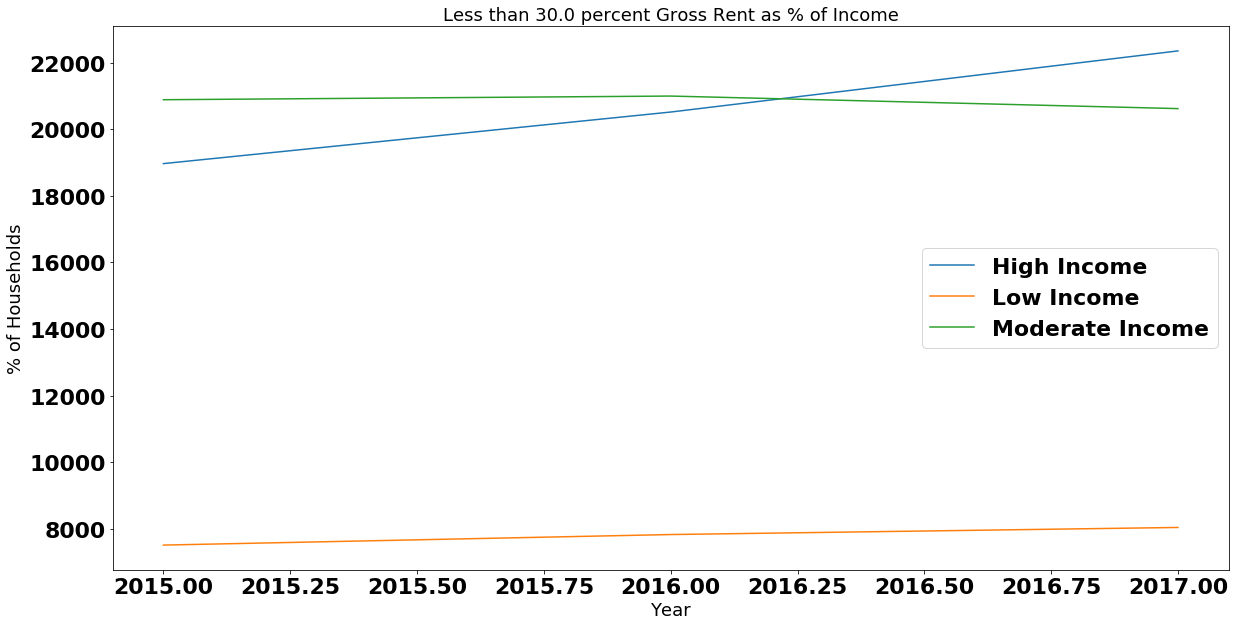

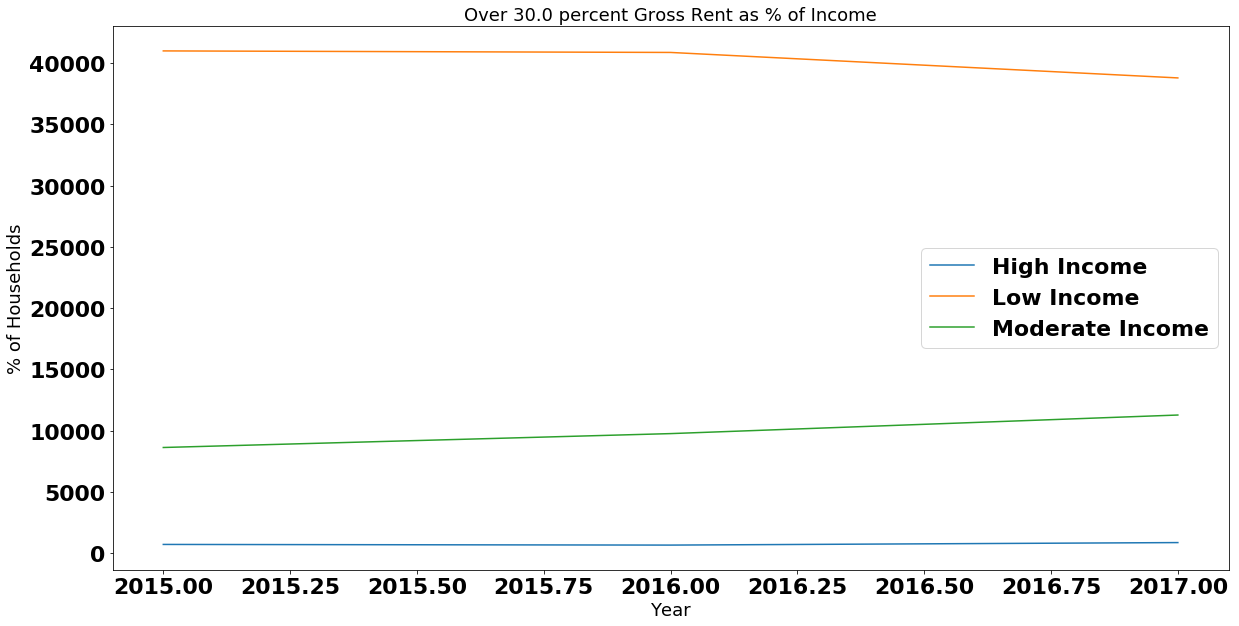

In [329]:
# Generate plot for Rent as % of Income

#Settings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#Variables
colors = {'Less than 30.0 percent':'red', 'Over 30.0 percent':'blue'}
groups = percentrentbyincomesum.groupby('Income')
percentbuckets = ['Less than 30.0 percent', 'Over 30.0 percent']
filename = 'Rent as % of Income'

#Loop through each bucket and make chart
for bucket in percentbuckets:
    fig, ax = plt.subplots(figsize=(20, 10))
    for name, group in groups:

        #print(name)

        x = percentrentbyincomesum.loc[percentrentbyincomesum.index==name, 'YEAR']
        y = percentrentbyincomesum.loc[percentrentbyincomesum.index==name, bucket]
        #print(percentbucket)
        plt.plot(x, y,color=colors.get(name), label=name)
    ax.legend()

    # Create a title, x label, and y label for our chart

    plt.title(bucket + ' ' + "Gross Rent as % of Income" , fontsize=18)
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("% of Households", fontsize=18)


    #Save the Figure
    plt.savefig("images/" + filename + ".png")
    plt.show()





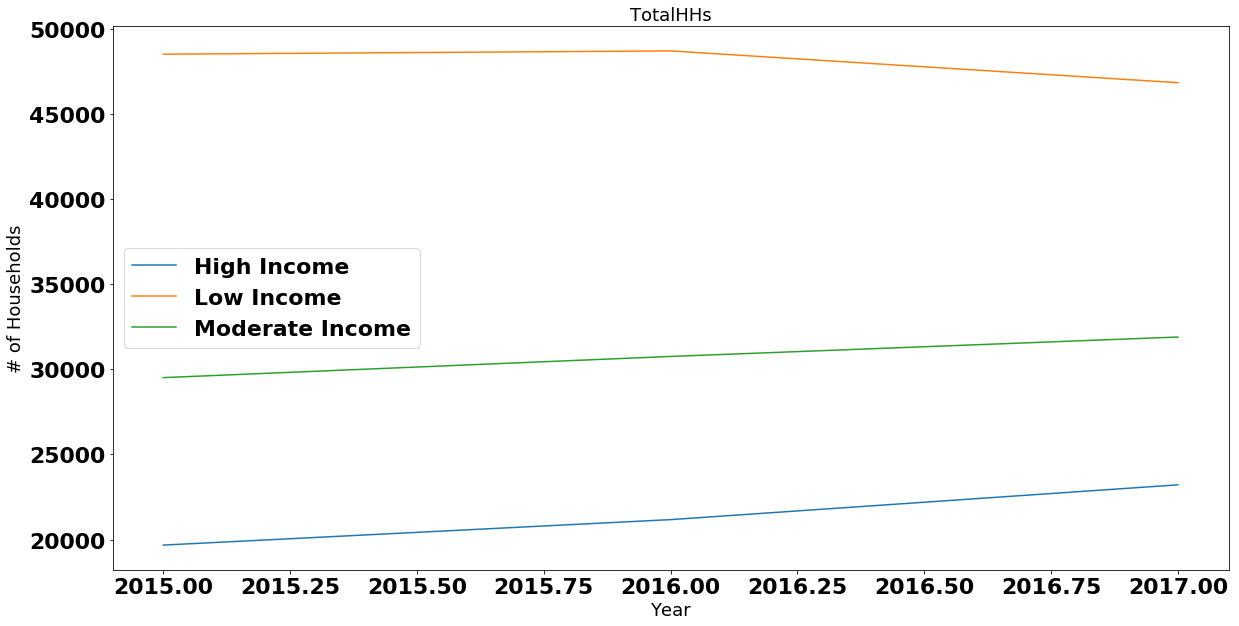

In [340]:
# Generate the Plot from percentrentbyincomesum for Total Households

#Drop irrelevant data
todrop = ['Less than 30.0 percent','Over 30.0 percent']
hhsbyincome = percentrentbyincomesum.drop(axis=1, columns=todrop)


# Settings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)



#Variables
colors = {'TotalHHs':'blue', '30.0 to 34.9 percent':'blue', '35.0 to 39.9 percent':'green', '40.0 to 49.9 percent':'black', '50.0 percent or more':'pink'}
groups = hhsbyincome.groupby('Income')
filename = 'Total Households'

#Loop through all buckets
percentbuckets = ['TotalHHs']
for bucket in percentbuckets:
    fig, ax = plt.subplots(figsize=(20, 10))
    for name, group in groups:

        #print(name)

        x = percentrentbyincomesum.loc[percentrentbyincomesum.index==name, 'YEAR']
        y = percentrentbyincomesum.loc[percentrentbyincomesum.index==name, bucket]
        #print(percentbucket)
        plt.plot(x, y,color=colors.get(name), label=name)
    ax.legend()

        # Create a title, x label, and y label for our chart

    plt.title(bucket, fontsize=18)
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("# of Households", fontsize=18)


    # Save the Figure
    plt.savefig("images/" + filename + ".png")
    
    #Display chart
    plt.show()




In [341]:
#Get Occupied Units by Rent Paid tables

occupiedunits = alltables['B25056']

#Group by year for simplicity
occupiedunits = occupiedunits.groupby('YEAR').sum()
occupiedunits = occupiedunits.transpose()


#Split index into relevant variables
occupiedunits['YEAR'] = occupiedunits.index
split1 = occupiedunits['YEAR'].str.split('!!', expand=True)
occupiedunits['Rent'] = split1[3]

#Backuptable for later
occupiedunitsog = occupiedunits.copy()

#Keep relevant results
occupiedunits.index = occupiedunits['Rent']
occupiedunits.drop(axis=1,columns=['Rent','YEAR'], inplace=True)
occupiedunits = occupiedunits.iloc[3:]

#Display table
display(occupiedunits)




YEAR,2015.0,2016.0,2017.0
Rent,,,
NaN,102110.0,104997.0,105867.0
Less than $100,2582.0,2470.0,2589.0
$100 to $149,1555.0,1638.0,1578.0
$150 to $199,2116.0,2077.0,1869.0
$200 to $249,2272.0,2246.0,2797.0
$250 to $299,1193.0,1350.0,1513.0
$300 to $349,1178.0,1307.0,1195.0
$350 to $399,1447.0,1359.0,1160.0
$400 to $449,1745.0,1836.0,1801.0


In [345]:
#Get Unoccupied Units by Rent Paid tables

unoccupiedunits = alltables['B25061']

#Aggregate table for simplicity
unoccupiedunits = unoccupiedunits.groupby('YEAR').sum()
unoccupiedunits = unoccupiedunits.transpose()

#Split index into relevant variables
unoccupiedunits['YEAR'] = unoccupiedunits.index
split1 = unoccupiedunits['YEAR'].str.split('!!', expand=True)
unoccupiedunits['Rent'] = split1[2]

#Keep relevant results
unoccupiedunits.index = unoccupiedunits['Rent']
unoccupiedunits.drop(axis=1,columns=['Rent','YEAR'], inplace=True)
unoccupiedunits = unoccupiedunits.iloc[3:]

#Display Table
display(unoccupiedunits)

YEAR,2015.0,2016.0,2017.0
Rent,,,
Less than $100,107.0,109.0,50.0
$100 to $149,149.0,86.0,114.0
$150 to $199,42.0,65.0,94.0
$200 to $249,151.0,74.0,77.0
$250 to $299,32.0,62.0,20.0
$300 to $349,73.0,131.0,115.0
$350 to $399,83.0,96.0,128.0
$400 to $449,135.0,152.0,145.0
$450 to $499,414.0,372.0,341.0


In [354]:
#Here we will take Occupied + Unoccupied rental Units to determine supply available
occupiedunits.dropna(inplace=True)
unoccupiedunits.dropna(inplace=True)


#Join both tables
allunits = occupiedunits.join(unoccupiedunits, how='outer',lsuffix=' Occupied Units', rsuffix=' Unoccupied Units')

#Clean up result
allunits = allunits.fillna(0)
allunits.dropna(inplace=True)


#Years to loop through
years = [2015.0,2016.0,2017.0]


#Loop through each year to organize data into one table
allunitsonly = pd.DataFrame()
for year in years:
    year = str(year)
    allunitsonly['All Units ' + year] = allunits[year + ' Unoccupied Units'] +allunits[year + ' Occupied Units']

 
####display(allunitsonly)
####display(unoccupiedunits.index.tolist())

#####allunitsonly = allunitsonly.reindex(unoccupiedunits.index.tolist())


allunitsonly.dropna(inplace=True)


#Need to sum results in each rental bracket
list0 =[0]*len(allunitsonly.columns)


#Define rent to income brackets
allunitsonly.loc['Rental Units Available to Low Income HHs'] = list0
allunitsonly.loc['Rental Units Available to Med Income HHs'] = list0
allunitsonly.loc['Rental Units Available to High Income HHs'] = list0


#Define Rental brackets
lowincomerent = ['Less than $100', '$100 to $149', '$150 to $199', '$200 to $249', '$250 to $299', '$300 to $349', '$350 to $399', '$400 to $449', '$450 to $499', '$500 to $549', '$550 to $599', '$600 to $649', '$650 to $699', '$700 to $749', '$750 to $799']
medincomerent = ['$800 to $899','$900 to $999', '$1,000 to $1,249', '$1,250 to $1,499', '$1,500 to $1,999']
highincomerent = ['$2,000 to $2,499', '$2,500 to $2,999', '$3,000 to $3,499', '$3,500 or more']

#Generate new rental bracekts
for low in lowincomerent:
    allunitsonly.loc['Rental Units Available to Low Income HHs'] += allunitsonly.loc[low]
    
for med in medincomerent:
    allunitsonly.loc['Rental Units Available to Med Income HHs'] += allunitsonly.loc[med]
    
for high in highincomerent:
    allunitsonly.loc['Rental Units Available to High Income HHs'] += allunitsonly.loc[high]

#Keep only the summarized rental brackets
allunitsonlysum = allunitsonly.tail(3)


print('Affordable Supply in each bracket')
display(allunitsonlysum)




Affordable Supply in each bracket


,All Units 2015.0,All Units 2016.0,All Units 2017.0
Rent,,,
Rental Units Available to Low Income HHs,57467.0,55721.0,51139.0
Rental Units Available to Med Income HHs,55024.0,58104.0,62716.0
Rental Units Available to High Income HHs,3071.0,3655.0,4787.0


Rental Units Available to Low Income HHs
Rental Units Available to Med Income HHs
Rental Units Available to High Income HHs


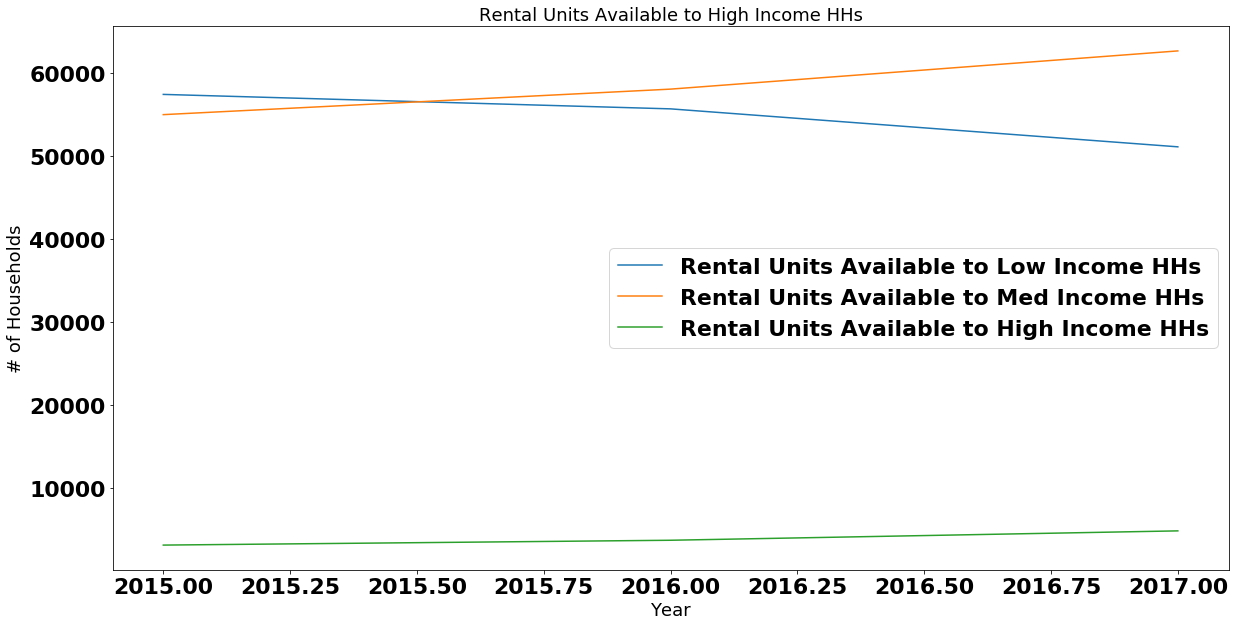

In [372]:
# Generate the Plot from percentrentbyincomesum for Total Households

# #Drop irrelevant data
# todrop = ['Less than 30.0 percent','Over 30.0 percent']
# hhsbyincome = percentrentbyincomesum.drop(axis=1, columns=todrop)


# Settings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)



#Variables
colors = {'All Units 2015.0':'blue', 'All Units 2016.0':'blue', 'All Units 2017.0':'green'}
filename = 'Total Households'
fig, ax = plt.subplots(figsize=(20, 10))
#Loop through all buckets
unitbuckets = allunitsonlysum.index.tolist()
for bucket in unitbuckets:

    print(bucket)

    y = allunitsonlysum.loc[bucket]
    x = [2015,2016,2017]
    #print(percentbucket)
    plt.plot(x, y,color=colors.get(bucket), label=bucket)

ax.legend()

    # Create a title, x label, and y label for our chart

plt.title(bucket, fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylabel("# of Households", fontsize=18)


# Save the Figure
plt.savefig("images/" + filename + ".png")

#Display chart
plt.show()




In [355]:
print('Demand in each bracket')
display(hhsbyincome)

Demand in each bracket


Rent as % of Income,YEAR,TotalHHs
Income,,
Low Income,2015.0,48503.0
Moderate Income,2015.0,29509.0
High Income,2015.0,19675.0
Low Income,2016.0,48695.0
Moderate Income,2016.0,30753.0
High Income,2016.0,21171.0
Low Income,2017.0,46828.0
Moderate Income,2017.0,31893.0
High Income,2017.0,23213.0
